Let's try to estimate the uncertainty on the median, for both normal & un-normal distributions, comparing "Standard" and bootstrap/jackknife methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
%matplotlib inline

In [128]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['font.size'] = 14

# Normal, symmetric distributions

In [3]:
NUM = 100000

In [4]:
def generate_normal_data(loc, scale, n):
    return np.random.normal(loc, scale, n)

In [5]:
x = generate_normal_data(1, 0.2, 100000)

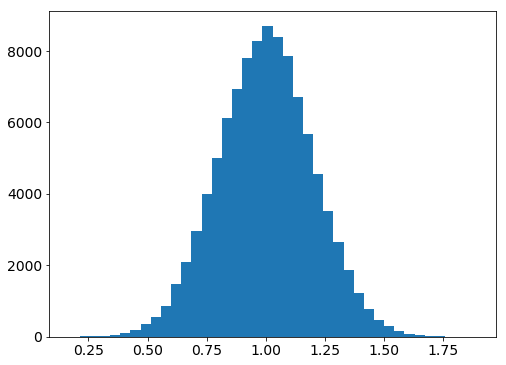

In [129]:
_ = plt.hist(x, bins=40)

In [7]:
np.median(x)

1.0004340992784362

The "standard" formula for the std dev on the median is: 
\begin{equation}
\delta = 1.253 \times \frac{RMS}{\sqrt{N}}
\end{equation}

where RMS is the std dev of the sample which has size N.

This approximation in theory only works well for symmetric gaussian-like distributions.

In [8]:
def standard_median_uncert(x):
    return 1.253 * np.std(x) / np.sqrt(len(x))

In [9]:
standard_median_uncert(x)

0.0007924585864123612

## Basic M-copy Monte Carlo estimate

Let us first test how well an approximation it is.
Let's do the following: we create M copies of the distributions, each with size N, and for each copy of the distribution calculate the median, and see what the resultant distribution (and its RMS) looks like:

In [201]:
# The Absolute Truth
loc, sigma = 1, 0.2

In [39]:
M = 1000
medians = []
N = np.logspace(1, 5, 5)
for n in N:
    print(n)
    n = int(n)
    these_medians = [np.median(generate_normal_data(loc, sigma, n)) for i in range(M)]
    medians.append(these_medians)

10.0
100.0
1000.0
10000.0
100000.0


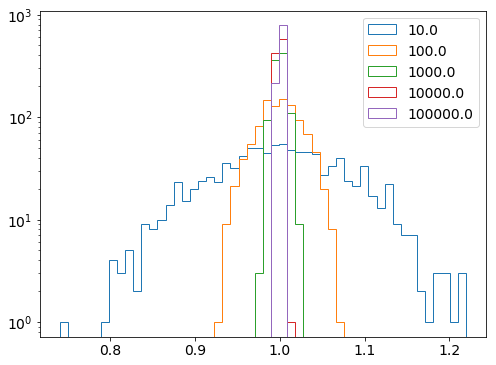

In [130]:
n, bins, _ = plt.hist(medians[0], label=str(N[0]), bins=50, histtype='step')
ax = plt.gca()
for i in range(1, len(N)):
    ax.hist(medians[i], label=str(N[i]), bins=bins, histtype='step')
plt.legend()
plt.yscale('log')

In [41]:
rms = [np.std(xm) for xm in medians]

In [42]:
rms

[0.07738472264617542,
 0.025238042555194455,
 0.007682717829993502,
 0.0025234964057874137,
 0.0007673282760998133]

Text(0, 0.5, 'Uncertainty')

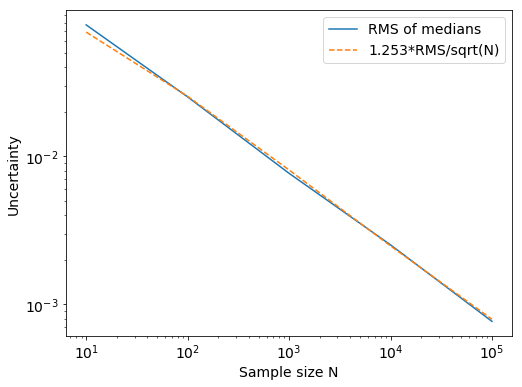

In [131]:
plt.plot(N, rms, label='RMS of medians');
plt.plot(N, [standard_median_uncert(generate_normal_data(loc, sigma, int(n))) for n in N], linestyle='dashed', label='1.253*RMS/sqrt(N)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Sample size N')
plt.ylabel('Uncertainty')

So the "standard" formula estimates very well the RMS of the distribution of medians (if you were to make many distributions), provided you have at least O(100) entries in your distribution. Below ~ 100 entries, the median is a biased estimator anyway.

## Normal distribution + jackknifing

Let's now try jackknifing - take a subset of our total dataset, calculate the median on that, and get the uncertainty on that estimate:

The jackknife estimate of the median is:

\begin{align}
\bar{x}_i &= \mathrm{median} \{ x_1, x_2, ... , x_{j\neq i}, ..., x_{N} \} \\
\bar{x} &= \frac{1}{N} \sum_{i=1}^{N} \bar{x}_i
\end{align}

whist the variation on that estimate is:

\begin{align}
\mathrm{Var}(\bar{x}) &= \frac{N}{N-1} \sum_{i=1}^{N} (\bar{x}_i - \bar{x})^2
\end{align}


In [44]:
all_data = generate_normal_data(loc, sigma, 10000)

In [95]:
def jackknife(x, func):
    """Jackknife estimate of the estimator func"""
    n = len(x)
    idx = np.arange(n)
    return np.sum(np.fromiter((func(x[idx!=i]) for i in range(n)), float))/float(n)

In [96]:
def jackknife_var(x, func):
    """Jackknife estiamte of the variance of the estimator func."""
    n = len(x)
    idx = np.arange(n)
    j_est = jackknife(x, func)
    j_var = (n-1)/(n + 0.0) * np.sum(np.fromiter(((func(x[idx!=i]) - j_est)**2.0 for i in range(n)), float))
    return j_est, j_var

In [97]:
jn, jn_var = jackknife_var(all_data, np.median)

In [89]:
print(jn, jn_std)

1.003923144408502 4.302569815266129e-06


In [202]:
jn_medians, jn_vars = [], []
true_median = []
standard_median_rms = []
N_jn = np.logspace(2, 4, 20)
for n in N_jn:
    print(n)
    n = int(n)
    this_data = generate_normal_data(loc, sigma, n)
    true_median.append(np.median(this_data))
    standard_median_rms.append(standard_median_uncert(this_data))
    jn, jn_var = jackknife_var(this_data, np.median)
    jn_medians.append(jn)
    jn_vars.append(jn_var)

100.0
127.42749857031335
162.3776739188721
206.913808111479
263.6650898730358
335.9818286283781
428.13323987193957
545.559478116852
695.1927961775606
885.8667904100823
1128.8378916846884
1438.449888287663
1832.9807108324355
2335.7214690901214
2976.351441631319
3792.69019073225
4832.930238571752
6158.48211066026
7847.5997035146065
10000.0


In [203]:
jn_medians = np.array(jn_medians)
jn_vars = np.array(jn_vars)
jn_stds = np.sqrt(jn_vars)
true_median = np.array(true_median)
standard_median_rms = np.array(standard_median_rms)

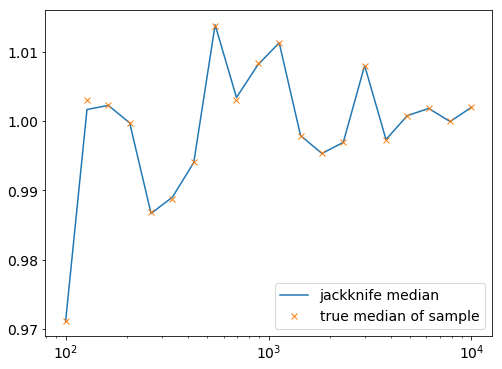

In [204]:
plt.plot(N_jn, jn_medians, label='jackknife median')
plt.plot(N_jn, true_median, 'x', label='true median of sample')
plt.xscale('log')
plt.legend()

In [205]:
np.abs(jn_medians - np.array([1]*len(jn_medians)))

array([2.88826553e-02, 1.67888279e-03, 2.26614085e-03, 2.54128321e-04,
       1.33144289e-02, 1.09746833e-02, 5.96636553e-03, 1.38848015e-02,
       3.41000487e-03, 8.11370415e-03, 1.12994514e-02, 2.08437419e-03,
       4.66402185e-03, 3.06610762e-03, 8.01287282e-03, 2.65289015e-03,
       8.00949667e-04, 1.82604738e-03, 5.41961070e-05, 1.98656299e-03])

Text(0.5, 0, 'Sample size N')

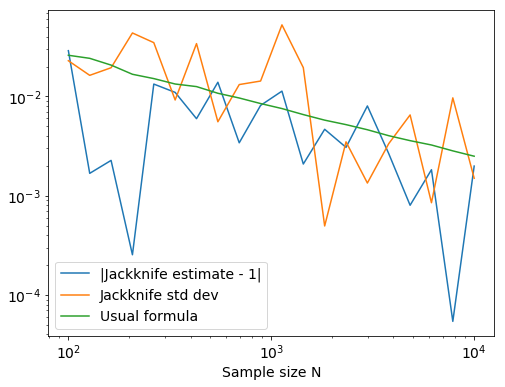

In [206]:
# plt.plot(N_jn, jn_medians - true_median, label='Difference between JN and true')
plt.plot(N_jn, np.abs(jn_medians - 1), label='|Jackknife estimate - 1|')
plt.plot(N_jn, jn_stds, label='Jackknife std dev')
plt.plot(N_jn, standard_median_rms, label='Usual formula')
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.ylim(1E-8, 1E-1)
plt.xlabel('Sample size N')

So it looks like the jackknife std dev is about the right size to cover the difference between the "true" median (=1) and the jackknife estimate. The usual formula of RMS/sqrt(N) looks a little more conservative? (A proper test here would be to do this many times, and check if the jackknife std dev covers the difference X% of the time, where X = 68?)

(Subtlety - we're not trying to estimate the uncert between JN estimate and the median of the N-size sample; instead the N-size sample is a finite sample from some infinitely-sized sample with "true" median 1. So we want to know if jackknifing is providing a good estimate of the uncert wrt that "true" 1)

## Normal distribution, bootstrapping

Here we just sample randomly from the distribution M times, each time calculating the median. One subtely is whether to replace the left-out data with existing dat in the dataset, such that we always have a sample size N.

In [208]:
n = 10
this_data = generate_normal_data(loc, sigma, n)

In [212]:
this_data

array([0.75194515, 0.70151515, 0.74172867, 0.91955365, 0.71694035,
       1.00996019, 0.63150038, 0.85644628, 0.6892044 , 1.31481787])

In [219]:
reps = 5
xb = np.random.choice(this_data, (reps, n), replace=True)
medians = np.median(xb, axis=1)

In [220]:
xb

array([[0.71694035, 0.70151515, 0.75194515, 0.63150038, 0.63150038,
        1.00996019, 1.00996019, 0.74172867, 0.70151515, 0.85644628],
       [0.63150038, 0.71694035, 0.74172867, 0.71694035, 0.85644628,
        0.75194515, 0.75194515, 0.71694035, 1.00996019, 0.85644628],
       [0.91955365, 1.00996019, 1.31481787, 0.6892044 , 0.74172867,
        0.74172867, 0.75194515, 0.70151515, 0.6892044 , 1.31481787],
       [1.00996019, 0.71694035, 1.00996019, 0.85644628, 0.85644628,
        0.74172867, 0.85644628, 1.00996019, 0.71694035, 1.00996019],
       [0.91955365, 0.74172867, 0.70151515, 1.00996019, 0.70151515,
        0.74172867, 0.91955365, 0.74172867, 0.75194515, 0.6892044 ]])

In [221]:
medians

array([0.72933451, 0.74683691, 0.74683691, 0.85644628, 0.74172867])

In [253]:
true_median = []

bs_medians = []
standard_median_rms = []

N_bs = np.logspace(2, 5, 7)

for n in N_bs:
    n = int(n)
    this_data = generate_normal_data(loc, sigma, n)
    true_median.append(np.median(this_data))
    reps = 1000
    xb = np.random.choice(this_data, (reps, n), replace=True)
    medians = np.median(xb, axis=1)
    bs_medians.append(medians)
    standard_median_rms.append(standard_median_uncert(this_data))

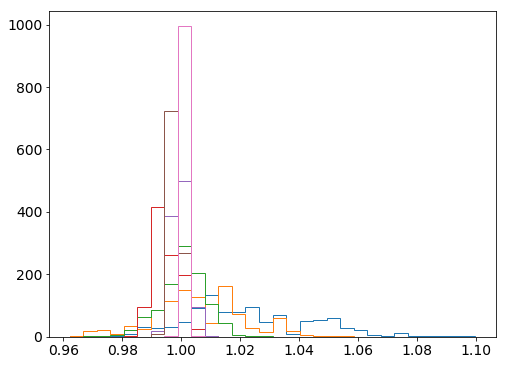

In [254]:
nn, bins, _ = plt.hist(bs_medians[0], label=str(N_bs[0]), bins=30, histtype='step')
ax = plt.gca()
for n, bs in zip(N_bs[1:], bs_medians[1:]):
    ax.hist(bs, bins=bins, label=str(n), histtype='step')
# plt.legend()

We can plot the mean from each:

In [255]:
bs_medians = np.array(bs_medians)

Text(0, 0.5, 'Mean of bootstraps')

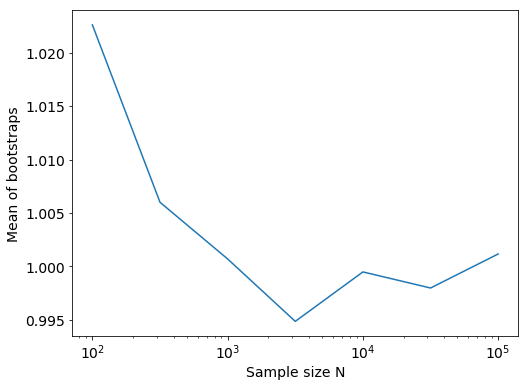

In [256]:
plt.plot(N_bs, np.mean(bs_medians, axis=1))
plt.xscale('log')
plt.xlabel('Sample size N')
plt.ylabel('Mean of bootstraps')

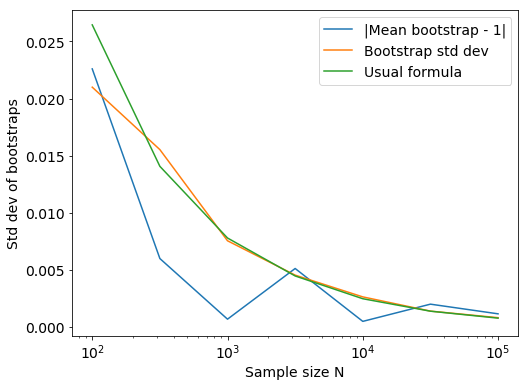

In [260]:
plt.plot(N_bs, np.abs(np.mean(bs_medians, axis=1) - 1), label='|Mean bootstrap - 1|')
plt.plot(N_bs, np.std(bs_medians, axis=1), label='Bootstrap std dev')
plt.plot(N_bs, standard_median_rms, label='Usual formula')
plt.xscale('log')
plt.xlabel('Sample size N')
plt.ylabel('Std dev of bootstraps')
plt.legend();

So the std dev of the bootstraps agrees quite nicely with the usual formula, and both cover the actual difference between the bootstrap estimate and the true median (1). 

NB: bootstrapping a lot faster than jackknifing (because we lean on numpy heavily, not some for looop)!

# Asymmetic non-gaussian distributions

In [261]:
def generate_skewed_data(loc, scale, n):
    return np.random.lognormal(loc, scale, n)

In [404]:
skew_loc, skew_width = 3, 0.4

In [405]:
x = generate_skewed_data(skew_loc, skew_width, 10000000)

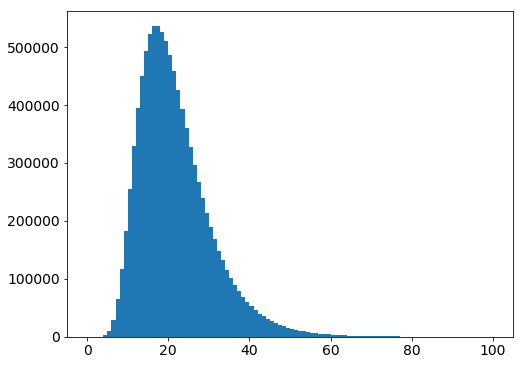

In [425]:
_ = plt.hist(x, bins=100, range=[0, 100])

In [426]:
true_median_skew = np.median(x)

In [427]:
print(true_median_skew)

20.086900786709876


So we have our skewed dataset

## Basic M-copy Monte Carlo estimate

In [409]:
M = 1000
medians = []
standard_median_rms = []
N = np.logspace(1, 5, 10)
for n in N:
    print(n)
    n = int(n)
    standard_median_rms.append(standard_median_uncert(generate_skewed_data(skew_loc, skew_width, n)))
    these_medians = [np.median(generate_skewed_data(skew_loc, skew_width, n)) for i in range(M)]
    medians.append(these_medians)

10.0
27.825594022071243
77.4263682681127
215.44346900318823
599.4842503189409
1668.100537200059
4641.588833612777
12915.496650148827
35938.13663804626
100000.0


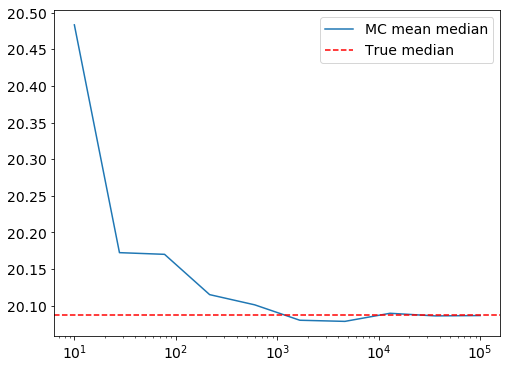

In [410]:
plt.plot(N, np.mean(np.array(medians), axis=1), label='MC mean median')
plt.xscale('log')
plt.axhline(true_median_skew, linestyle='dashed', c='red', label='True median')
plt.legend();

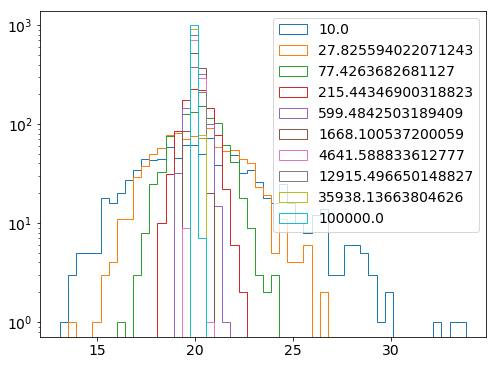

In [411]:
n, bins, _ = plt.hist(medians[0], label=str(N[0]), bins=50, histtype='step')
ax = plt.gca()
for i in range(1, len(N)):
    ax.hist(medians[i], label=str(N[i]), bins=bins, histtype='step')
plt.legend()
plt.yscale('log')

In [412]:
rms = [np.std(xm) for xm in medians]

In [413]:
rms

[3.059850689677158,
 1.987983828546213,
 1.150585105615842,
 0.6890447120519562,
 0.4083123489725286,
 0.24454396681680168,
 0.14360283832212326,
 0.08964660660396717,
 0.05139594567311699,
 0.031106042715653422]

Text(0, 0.5, 'Uncertainty')

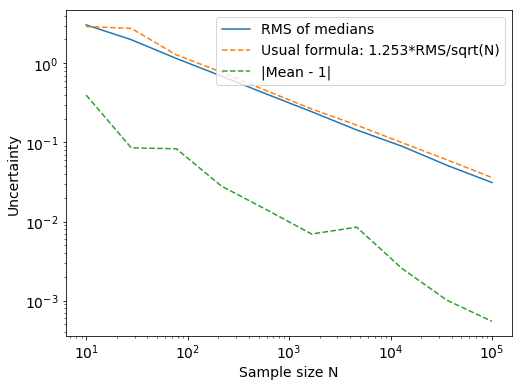

In [414]:
plt.plot(N, rms, label='RMS of medians');
plt.plot(N, standard_median_rms, linestyle='dashed', label='Usual formula: 1.253*RMS/sqrt(N)')
plt.plot(N, np.abs(np.mean(np.array(medians), axis=1) - true_median_skew), linestyle='dashed', label='|Mean - 1|')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel('Sample size N')
plt.ylabel('Uncertainty')

So surprisingly, the standard formula does rather well above N = 100 ? (Central limit theorem?) Interestingly, in this case, they both seem to be much larger than the difference between the mean of the medians and the true median.

## Skewed distribution + jackknifing

In [415]:
jn_medians, jn_vars = [], []
true_median = []
standard_median_rms = []
N_jn = np.logspace(2, 4, 20)
for n in N_jn:
    print(n)
    n = int(n)
    this_data = generate_skewed_data(skew_loc, skew_width, n)
    true_median.append(np.median(this_data))
    standard_median_rms.append(standard_median_uncert(this_data))
    jn, jn_var = jackknife_var(this_data, np.median)
    jn_medians.append(jn)
    jn_vars.append(jn_var)

100.0
127.42749857031335
162.3776739188721
206.913808111479
263.6650898730358
335.9818286283781
428.13323987193957
545.559478116852
695.1927961775606
885.8667904100823
1128.8378916846884
1438.449888287663
1832.9807108324355
2335.7214690901214
2976.351441631319
3792.69019073225
4832.930238571752
6158.48211066026
7847.5997035146065
10000.0


In [416]:
jn_medians = np.array(jn_medians)
jn_vars = np.array(jn_vars)
jn_stds = np.sqrt(jn_vars)
true_median = np.array(true_median)
standard_median_rms = np.array(standard_median_rms)

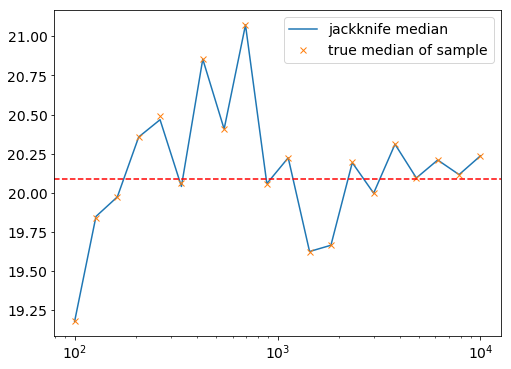

In [417]:
plt.plot(N_jn, jn_medians, label='jackknife median')
plt.plot(N_jn, true_median, 'x', label='true median of sample')
plt.xscale('log')
plt.legend()
plt.axhline(true_median_skew, linestyle='dashed', c='red', label='True median')

Text(0.5, 0, 'Sample size N')

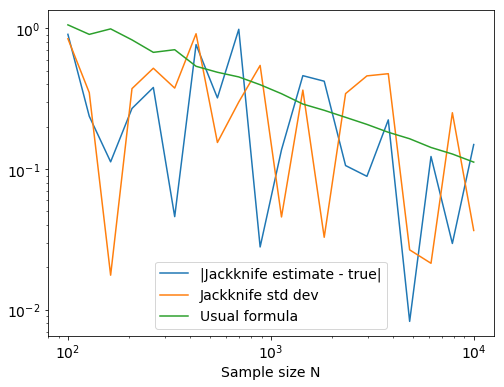

In [418]:
# plt.plot(N_jn, jn_medians - true_median, label='Difference between JN and true')
plt.plot(N_jn, np.abs(jn_medians - true_median_skew), label='|Jackknife estimate - true|')
plt.plot(N_jn, jn_stds, label='Jackknife std dev')
plt.plot(N_jn, standard_median_rms, label='Usual formula')
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.ylim(1E-8, 1E-1)
plt.xlabel('Sample size N')

So again the usual formula agrees with the jackknife std dev suprisingly. This time both are much similar in size to the difference between the jackknife estimator and the truth. A slightly undesirable result is that the jackknife std dev doesn't fall smoothly as a function of N (infact it looks ~ constant)

## Skewed distribution, bootstrapping

Here we just sample randomly from the distribution M times, each time calculating the median. One subtely is whether to replace the left-out data with existing dat in the dataset, such that we always have a sample size N.

In [419]:
true_median = []

bs_medians = []
standard_median_rms = []

N_bs = np.logspace(2, 5, 12)

for n in N_bs:
    n = int(n)
    this_data = generate_skewed_data(skew_loc, skew_width, n)
    true_median.append(np.median(this_data))
    reps = 1000
    xb = np.random.choice(this_data, (reps, n), replace=True)
    medians = np.median(xb, axis=1)
    bs_medians.append(medians)
    standard_median_rms.append(standard_median_uncert(this_data))

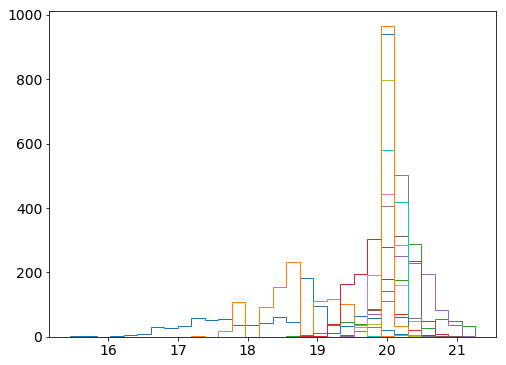

In [420]:
nn, bins, _ = plt.hist(bs_medians[0], label=str(N_bs[0]), bins=30, histtype='step')
ax = plt.gca()
for n, bs in zip(N_bs[1:], bs_medians[1:]):
    ax.hist(bs, bins=bins, label=str(n), histtype='step')
# plt.legend()

We can plot the mean from each:

In [421]:
bs_medians = np.array(bs_medians)

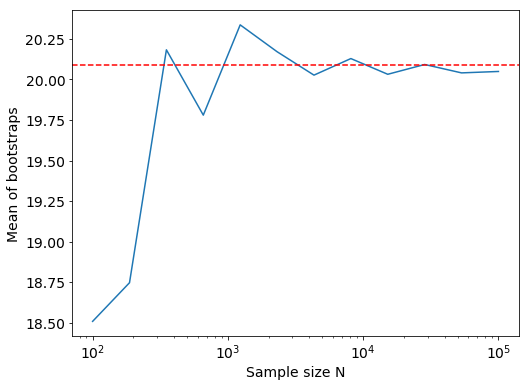

In [422]:
plt.plot(N_bs, np.mean(bs_medians, axis=1))
plt.xscale('log')
plt.xlabel('Sample size N')
plt.ylabel('Mean of bootstraps')
plt.axhline(true_median_skew, linestyle='dashed', c='red', label='True median');

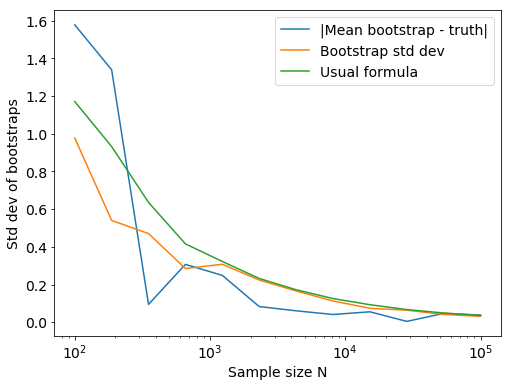

In [423]:
plt.plot(N_bs, np.abs(np.mean(bs_medians, axis=1) - true_median_skew), label='|Mean bootstrap - truth|')
plt.plot(N_bs, np.std(bs_medians, axis=1), label='Bootstrap std dev')
plt.plot(N_bs, standard_median_rms, label='Usual formula')
plt.xscale('log')
plt.xlabel('Sample size N')
plt.ylabel('Std dev of bootstraps')
plt.legend();

So again here we have similar results between the two methods, and again of similar size to the difference between the estimator and the truth. What is nice is that the bootstrap std dev falls ~ smoothly as a fn of N.

# Conclusion

It looks like the "usual" lazy formula actually works quite well, even when the distribution is moderately skewed. However, once you go below a sample size of N ~ 500 for a skewed distribution (~100 for gaussian), you can run into trouble.

Possible improvements: try proper quantiles? Since that is closer to what is actually represented by an uncertainty band (68% CI)